In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [8]:
%aimport src.lsh
%aimport settings
%aimport src.hashes
%aimport src.utils

In [7]:
import os
import sys
sys.path.append(os.environ.get("ALGO_COURSE_WORK_REPO"))

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
from src.hashes import MinHash
from src.utils import bytes_to_crc_32_int, bytes_to_sha_256_int
from src.lsh import MinHashLSH, CosineLSH

In [11]:
data = ["hello world . I'm here for you .",
        "how are you ?",
        "I don't give a fuck .",
        "hello .",
        "world ."
       ]
minhashes = {}
num_permutations = 128
hash_function = bytes_to_crc_32_int

for k, sentence in enumerate(data):
    mh = MinHash(num_permutations=num_permutations, seed=10, hash_function=hash_function)
    for token in sentence.split():
        mh.update(token.encode("utf-8"))
    minhashes[k] = mh
        
lsh = MinHashLSH(num_permutations=num_permutations, threshold=0.8)
lsh.batch_add(minhashes)
lsh.index()

# Query
query = "hello world ."
mh = MinHash(num_permutations=num_permutations, seed=10, hash_function=hash_function)
for token in query.split():
    mh.update(token.encode("utf-8"))
idx = lsh.query(mh, k=100)
print(f"Best neighbour: `{idx}`")

Best neighbour: `[3, 4, 0]`


In [12]:
ch = CosineLSH(hash_size=2 ** 10, input_dim=100)
vector1 = np.random.randn(100)
vector2 = np.random.randn(100)
vector3 = np.random.randn(100)

ch.batch_index({1: vector1, 
                2: vector2, 
                3: vector3 * 0.1 + vector2 * 0.9})
ch.query(vector2 * 0.9 + vector3 * 0.1, 10)

NameError: name 'np' is not defined

In [691]:
# Plots and performance

#### Benchmark for MinHash LSH

In [13]:
import sklearn
import nltk

In [44]:
import time, argparse, sys, json
import numpy as np
import nltk
import scipy.stats
import random
import collections

def bootstrap_data(num_perms, n, population_size, set_size_dist):
    random.seed(42)
    print("Creating sets...")
    population = [str(i) for i in range(population_size)]
    sets = [set(random.sample(population, set_size_dist.rvs()))
            for _ in range(n)]
    keys = list(range(len(sets)))
    print("Creating minhashes...")
    minhashes = dict()
    for num_perm in num_perms:
        ms = []
        for s in sets:
            m = MinHash(num_permutations=num_perm)
            for word in s:
                m.update(word.encode("utf8"))
            ms.append(m)
        minhashes[num_perm] = ms
    Data = collections.namedtuple('Data', ['minhashes', 'sets', 'keys'])
    index_data = Data(minhashes, sets, keys)
    query_indices = random.sample(list(range(len(sets))), int(len(sets)*0.1))
    if len(query_indices) == 0:
        raise RuntimeError("Empty query sets")
    query_data = Data(dict((num_perm, [minhashes[num_perm][i] for i in query_indices])
                           for num_perm in num_perms),
                      [sets[i] for i in query_indices],
                      [keys[i] for i in query_indices])
    return index_data, query_data


def get_twitter_data(num_perms, subset):
    nltk.download("stopwords")
    nltk.download("twitter_samples")
    stopwords = set(nltk.corpus.stopwords.words("english"))
    tweets = nltk.corpus.twitter_samples.tokenized('tweets.20150430-223406.json')[:subset]
    minhashes = []
    sets = []
    print("Creating sets...")
    for i, text in enumerate(tweets):
        s = set(w for w in text
                if w not in stopwords)
        if len(s) == 0:
            continue
        sets.append(s)
    keys = list(range(len(sets)))
    print("Creating MinHash...")
    minhashes = dict()
    for num_perm in num_perms:
        ms = []
        for s in sets:
            m = MinHash(num_permutations=num_perm)
            for word in s:
                m.update(word.encode("utf8"))
            ms.append(m)
        minhashes[num_perm] = ms
    Data = collections.namedtuple('Data', ['minhashes', 'sets', 'keys'])
    index_data = Data(minhashes, sets, keys)
    query_indices = random.sample(list(range(len(sets))), int(len(sets)*0.1))
    if len(query_indices) == 0:
        raise RuntimeError("Empty query sets")
    query_data = Data(dict((num_perm, [minhashes[num_perm][i] for i in query_indices])
                           for num_perm in num_perms),
                      [sets[i] for i in query_indices],
                      [keys[i] for i in query_indices])
    return index_data, query_data


def benchmark_lshforest(num_perm, l, k, index_data, query_data):
    print("Building LSH Forest index")
    forest = MinHashLSHForest(num_perm, l)#(num_permutations=num_perm, params=(l, num_perm // l))
    for key, minhash in zip(index_data.keys, index_data.minhashes[num_perm]):
        forest.add(key, minhash)
    forest.index()
    print("Querying")
    times = []
    results = []
    for qs, minhash in zip(query_data.sets, query_data.minhashes[num_perm]):
        start = time.clock()
        result = forest.query(minhash, k)
        duration = time.clock() - start
        times.append(duration)
        results.append(sorted([[key, _compute_jaccard(qs, index_data.sets[key])]
                               for key in result],
                              key=lambda x : x[1], reverse=True))
    return times, results


def benchmark_linearscan(num_perm, k, index_data, query_data):
    times = []
    results = []
    for qs, q in zip(query_data.sets, query_data.minhashes[num_perm]):
        start = time.clock()
        result = []
        result = [(key, q.jaccard(m))
                  for key, m in zip(index_data.keys, index_data.minhashes[num_perm])]
        result.sort(key=lambda x : x[1], reverse=True)
        result = [x[0] for x in result[:k]]
        duration = time.clock() - start
        times.append(duration)
        results.append(sorted([[key, _compute_jaccard(qs, index_data.sets[key])]
                               for key in result],
                              key=lambda x : x[1], reverse=True))
    return times, results


def benchmark_ground_truth(k, index_data, query_data):
    times = []
    results = []
    # use less decimal precision for collecting top-k ground truth
    truncate_decimal = lambda x : float(int(x*100)) / 100.0
    for q in query_data.sets:
        start = time.clock()
        result = [(key, _compute_jaccard(q, a))
                  for key, a in zip(index_data.keys, index_data.sets)]
        result.sort(key=lambda x : x[1], reverse=True)
        duration = time.clock() - start
        topk_result = []
        curr_rank = 0
        curr_j2 = -1.0
        for key, j in result:
            j2 = truncate_decimal(j)
            if j2 != curr_j2:
                curr_j2 = j2
                curr_rank += 1
            if curr_rank > k:
                break
            topk_result.append([key, j])
        # assert(len(set(truncate_decimal(x[1]) for x in topk_result)) == k)
        results.append(topk_result)
        times.append(duration)
    return times, results


def _compute_jaccard(x, y):
    if len(x) == 0 or len(y) == 0:
        return 0.0
    intersection = 0
    for w in x:
        if w in y:
            intersection += 1
    return float(intersection) / float(len(x) + len(y) - intersection)


num_perms = [32, 64, 96, 128, 160, 192, 224, 256]
l = 8
k = 10
output = {"num_perms" : num_perms,
          "l" : l,
          "k" : k,
          "lsh_times" : [], "lsh_results" : [],
          "linearscan_times" : [], "linearscan_results" : [],
          "ground_truth_times" : None, "ground_truth_results" : None}
# index_data, query_data = bootstrap_data(num_perms, 1000, 5000,
#         scipy.stats.randint(10, 5000))

for num_perm in num_perms:
    print("Use num_perm = %d" % num_perm)
    result = {}
    print("Running LSH benchmark l = %d" % l)
    lsh_times, lsh_results = benchmark_lshforest(num_perm, l, k, index_data, query_data)
    print("Running linear scan benchmark")
    linearscan_times, linearscan_results = benchmark_linearscan(num_perm, k, index_data, query_data)
    output["lsh_times"].append(lsh_times)
    output["lsh_results"].append(lsh_results)
    output["linearscan_times"].append(linearscan_times)
    output["linearscan_results"].append(linearscan_results)

print("Running ground truth benchmark")
output["ground_truth_times"], output["ground_truth_results"] =\
        benchmark_ground_truth(k, index_data, query_data)

average_cardinality = np.mean([len(s) for s in
    index_data.sets + query_data.sets])
print("Average cardinality is", average_cardinality)

Use num_perm = 32
Running LSH benchmark l = 8
Building LSH Forest index
Querying


/Users/karimlulu/miniconda3/envs/algo/lib/python3.7/site-packages/ipykernel_launcher.py:84: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/karimlulu/miniconda3/envs/algo/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Running linear scan benchmark


/Users/karimlulu/miniconda3/envs/algo/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/karimlulu/miniconda3/envs/algo/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Use num_perm = 64
Running LSH benchmark l = 8
Building LSH Forest index
Querying
Running linear scan benchmark
Use num_perm = 96
Running LSH benchmark l = 8
Building LSH Forest index
Querying
Running linear scan benchmark
Use num_perm = 128
Running LSH benchmark l = 8
Building LSH Forest index
Querying
Running linear scan benchmark
Use num_perm = 160
Running LSH benchmark l = 8
Building LSH Forest index
Querying
Running linear scan benchmark
Use num_perm = 192
Running LSH benchmark l = 8
Building LSH Forest index
Querying
Running linear scan benchmark
Use num_perm = 224
Running LSH benchmark l = 8
Building LSH Forest index
Querying
Running linear scan benchmark
Use num_perm = 256
Running LSH benchmark l = 8
Building LSH Forest index
Querying
Running linear scan benchmark
Running ground truth benchmark


/Users/karimlulu/miniconda3/envs/algo/lib/python3.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/karimlulu/miniconda3/envs/algo/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Average cardinality is 2570.0454545454545


In [31]:
import json, sys, argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


def get_precision_recall(found, reference):
    reference = set(reference)
    intersect = sum(1 for i in found if i in reference)
    if len(found) == 0:
        precision = 0.0
    else:
        precision = float(intersect) / float(len(found))
    if len(reference) == 0:
        recall = 1.0
    else:
        recall = float(intersect) / float(len(reference))
    if len(found) == len(reference) == 0:
        precision = 1.0
        recall = 1.0
    return [precision, recall]

def fscore(precision, recall):
    if precision == 0.0 and recall == 0.0:
        return 0.0
    return 2.0 / (1.0 / precision + 1.0 / recall)

def average_fscore(founds, references):
    return np.mean([fscore(*get_precision_recall(found, reference))
                    for found, reference in zip(founds, references)])

In [16]:
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if len(actual) == 0:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [45]:
benchmark = output

Text(0, 0.5, 'MAP @ 10')

Text(0.5, 0, 'No. of hash functions')

Text(0.5, 0, 'No. of hash functions')

Text(0, 0.5, 'time (median, ms)')

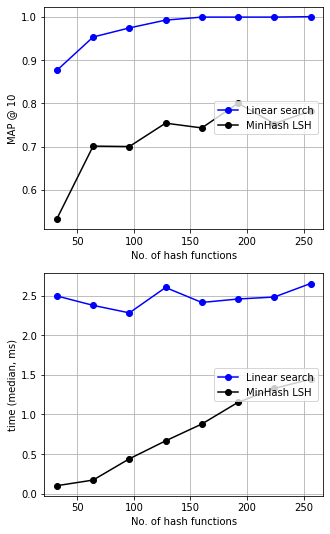

In [68]:
import json, sys, argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


num_perms = benchmark["num_perms"]
lsh_times = benchmark["lsh_times"]
linearscan_times = benchmark["linearscan_times"]
ground_truth_results = [[x[0] for x in r] for r in benchmark["ground_truth_results"]]
k = 10
lsh_maps = []
for results in benchmark["lsh_results"]:
    query_results = [[x[0] for x in r] for r in results]
    lsh_maps.append(mapk(ground_truth_results, query_results, k))
linearscan_maps = []
for results in benchmark["linearscan_results"]:
    query_results = [[x[0] for x in r] for r in results]
    linearscan_maps.append(mapk(ground_truth_results, query_results, k))

lsh_times = np.array([np.percentile(ts, 50) 
    for ts in lsh_times])*1000
linearscan_times = np.array([np.percentile(ts, 50) 
    for ts in linearscan_times])*1000

fig, axes = plt.subplots(2, 1, figsize=(5, 4.5*2), sharex=False)
# Plot query average MAP vs. num perm
axes[0].plot(num_perms, linearscan_maps, marker="o", label="Linear search", color="b")
axes[0].plot(num_perms, lsh_maps, marker="o", label="MinHash LSH", color="k")
axes[0].set_ylabel("MAP @ %d" % k)
axes[0].set_xlabel("No. of hash functions")
axes[0].grid()
axes[0].legend(loc="center right")
# Plot query time vs. num perm
axes[1].plot(num_perms, linearscan_times, marker="o", label="Linear search", color="b")
axes[1].plot(num_perms, lsh_times, marker="o", label="MinHash LSH", color="k")
axes[1].set_xlabel("No. of hash functions")
axes[1].set_ylabel("time (median, ms)")
axes[1].grid()
axes[1].legend(loc="center right")
fig.savefig("lshforest_benchmark.png", pad_inches=0.05, bbox_inches="tight")
plt.show()